# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import random
import cv2

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from skimage import color
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.contrib.layers import flatten


# TODO: Fill this in based on where you saved the training and testing data

training_file = "train.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
# n_train = len(train['features'])
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

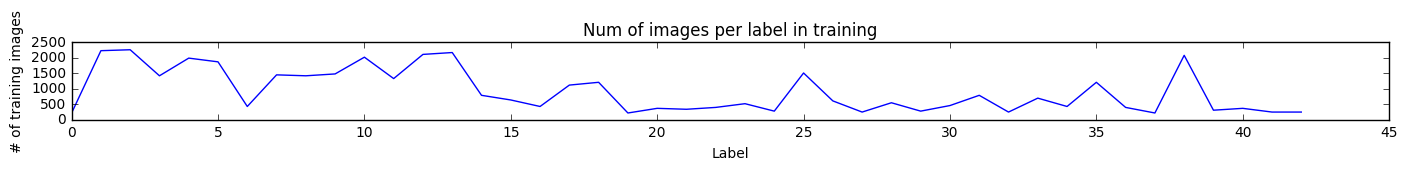

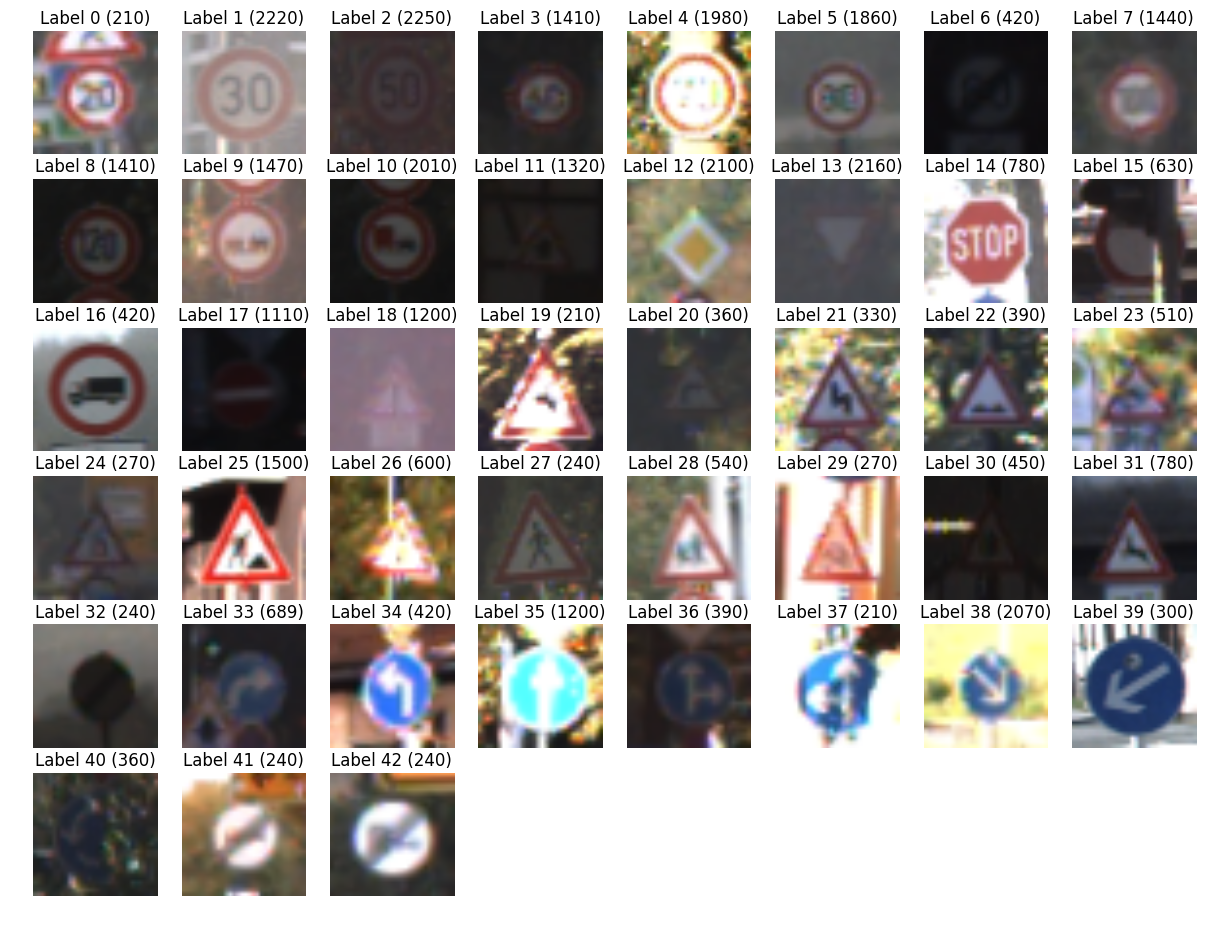

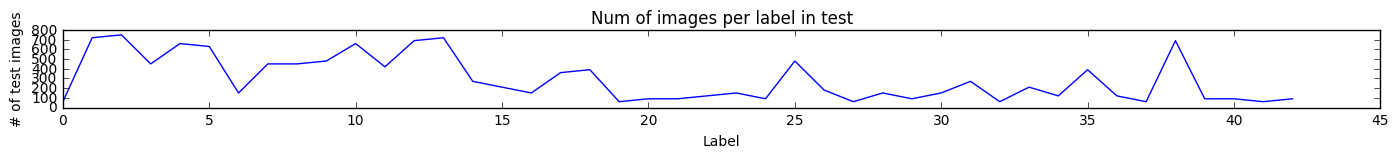

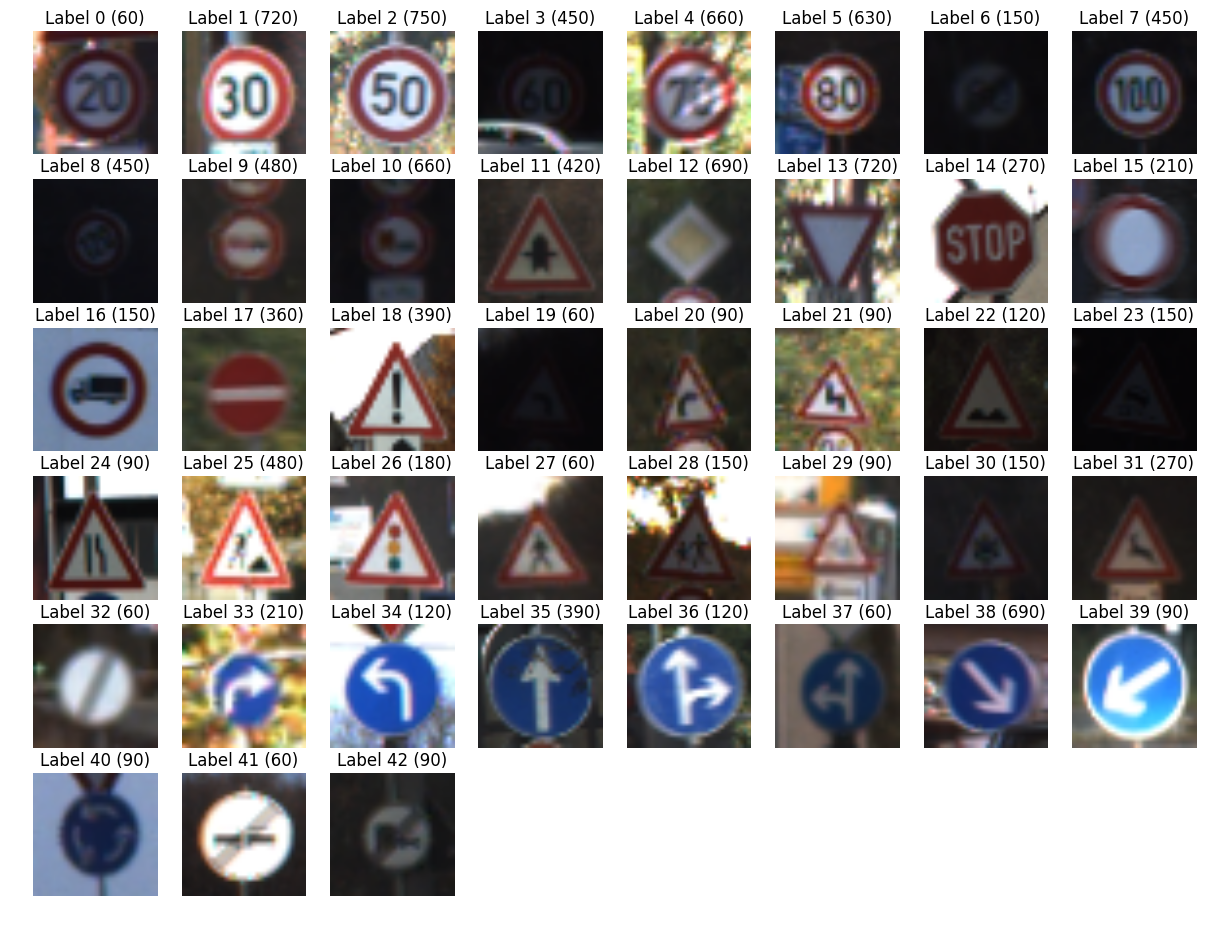

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

# Visualizations will be shown in the notebook.
%matplotlib inline

def display_images_and_labels(images, labels):
    """Display the first image of each label."""
    labels = labels.tolist()
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        image = images[labels.index(label)]
        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image)
    plt.show()

    
# Calculate number of images per label in training set
num_per_label_tr = np.unique(train['labels'], return_counts=True)

# Display number of images per label
plt.figure(figsize=(17,1))
plt.plot(num_per_label_tr[0], num_per_label_tr[1])

plt.title('Num of images per label in training')
plt.xlabel('Label')
plt.ylabel('# of training images')

# Display sample image for each label in training set
display_images_and_labels(X_train, y_train)

# Calculate number of images per label in test set
num_per_label_te = np.unique(test['labels'], return_counts=True)

# Display number of images per label
plt.figure(figsize=(17,1))
plt.plot(num_per_label_te[0], num_per_label_te[1])

plt.title('Num of images per label in test')
plt.xlabel('Label')
plt.ylabel('# of test images')

# Display sample image for each label in test set
display_images_and_labels(X_test, y_test)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [4]:
# First I shuffle the data
X_train, y_train = shuffle(X_train, y_train)

In [5]:
# Then I convert the data to greyscale
def preprocess(data):
    """Convert to grayscale, histogram equalize, and expand dims"""
    imgs = np.ndarray((data.shape[0], 32, 32, 1), dtype=np.uint8)
    for i, img in enumerate(data):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.equalizeHist(img)
        img = np.expand_dims(img, axis=2)
        imgs[i] = img
    return imgs

X_train_grey = preprocess(X_train)
X_test_grey = preprocess(X_test)

In [6]:
# Then I normalize the greyscale data
def center_normaize(data, mean, std):
    """Center normalize images"""
    data = data.astype('float32')
    data -= mean
    data /= std
    return data

mean = np.mean(X_train_grey)
std = np.std(X_train_grey)

X_train_norm = center_normaize(X_train_grey, mean, std)
X_test_norm = center_normaize(X_test_grey, mean, std)

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:** I shuffled the data and transformed into Greyscale image with an additional dimension to fit into LeNet-5. In addition I normalized the data to greyscale and one-hot encoded the labels

In [7]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

#Splitting out 20% of data as validation
X_train_final, X_validation_final, y_train_final, y_validation_final = train_test_split(X_train_norm, y_train, test_size=0.3, random_state=0)
X_test_final, y_test_final = X_test_norm, y_test
n_train = len(X_train_final)

print("Size of X_train_final: ", X_train_final.shape)
print("Size of X_validation_final ", X_validation_final.shape)
print("Size of X_test_final: ", X_test_final.shape)
print("Size of y_train_final: ", y_train_final.shape)
print("Size of y_validation_final: ", y_validation_final.shape)
print("Size of y_test_final: ", y_test_final.shape)


Size of X_train_final:  (27446, 32, 32, 1)
Size of X_validation_final  (11763, 32, 32, 1)
Size of X_test_final:  (12630, 32, 32, 1)
Size of y_train_final:  (27446,)
Size of y_validation_final:  (11763,)
Size of y_test_final:  (12630,)


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**
Took out 30% of training data as validation data. Test data already specified.
Overall I have now 3 sets of data: train, validation, test

In [8]:
# Define helper functions

def conv2d_same(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def conv2d_valid(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d_same(x, k=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='SAME')

def maxpool2d_valid(x, k=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='VALID')

In [9]:
# Define CNN AlexNet y= Wx+b
def conv_net_alex(x, weights, biases, dropout):
    
    conv1 = conv2d_same(x, weights['layer_1_alex'], biases['layer_1_alex'])
    conv1 = maxpool2d_same(conv1)

    conv2 = conv2d_same(conv1, weights['layer_2_alex'], biases['layer_2_alex'])
    conv2 = maxpool2d_same(conv2)

    conv3 = conv2d_same(conv2, weights['layer_3_alex'], biases['layer_3_alex'])
    conv4 = conv2d_same(conv3, weights['layer_4_alex'], biases['layer_4_alex'])
    conv4 = maxpool2d_same(conv4)

    fc1 = flatten(conv4)
    
    fc1 = tf.add(tf.matmul(fc1, weights['dense_1_alex']), biases['dense_1_alex'])
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, dropout_prob)
    
    fc2 = tf.add(tf.matmul(fc1, weights['dense_2_alex']), biases['dense_2_alex'])
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, dropout_prob)
    
    out = tf.add(tf.matmul(fc2, weights['out_alex']), biases['out_alex'])
    
    return out

In [10]:
# Define CNN LeNet-5
def conv_net_lenet(x, weights, biases):    
    
    conv1 = conv2d_valid(x, weights['layer_1_lenet'], biases['layer_1_lenet'])
    conv1 = maxpool2d_valid(conv1)

    conv2 = conv2d_valid(conv1, weights['layer_2_lenet'], biases['layer_2_lenet'])
    conv2 = maxpool2d_valid(conv2)
    
    fc0   = flatten(conv2)
    
    fc1 = tf.add(tf.matmul(fc0, weights['dense_1_lenet']), biases['dense_1_lenet'])
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, dropout_prob)
    
    fc2 = tf.add(tf.matmul(fc1, weights['dense_2_lenet']), biases['dense_2_lenet'])
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, dropout_prob)
    
    out = tf.add(tf.matmul(fc2, weights['out_lenet']), biases['out_lenet'])
    
    return out

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

Initially I tried the LeNet-5 architecture.
Layer overview:
1. Input: (32, 32, 1)
2. Conv: (28, 28, 6)
3. Pool: (14, 14, 6)
4. Conv: (10, 10, 16)
5. Pool: (5, 5, 16)
6. Flatten: (400)
7. FullyConnected: (120)
8. FullyConnected: (84)
9. Output: (43)


Network is based on AlexNet. I tried LeNet-5 first but results were unsatisfactory...

Layer overview:
1. Input: (32, 32, 1)
2. Conv: (32, 32, 64)
3. Pool: (16, 16, 64)
4. Conv: (16, 16, 128)
5. Pool: (8, 8, 128)
6. Conv: (8, 8, 256)
7. Conv: (8, 8, 256)
8. Pool: (4, 4, 256)
9. Flatten: (2048)
10. FullyConnected: (400)
11. Dropout 0.5
12. FullyConnected: (200)
13. Dropout 0.5
14. Output: (43)

In [59]:
#Define Overall Parameters (both AlexNet and LeNet-5)
learning_rate = 0.001
batch_size = 256
training_epochs = 100
n_classes = 43
dropout_prob = 0.5
sigma = 0.001

In [60]:
#Define LeNet-5 Parameters

layer_width_lenet = {
    'layer_1_lenet': 6,
    'layer_2_lenet': 16,
    'dense_1_lenet': 120,
    'dense_2_lenet': 84
}

weights_lenet = {
    'layer_1_lenet': tf.Variable(tf.truncated_normal(
        [3, 3, 1, layer_width_lenet['layer_1_lenet']], stddev=sigma)),
    'layer_2_lenet': tf.Variable(tf.truncated_normal(
        [3, 3, layer_width_lenet['layer_1_lenet'], layer_width_lenet['layer_2_lenet']], stddev=sigma)),
    'dense_1_lenet': tf.Variable(tf.truncated_normal(
        [576, layer_width_lenet['dense_1_lenet']], stddev=sigma)),
    'dense_2_lenet': tf.Variable(tf.truncated_normal(
        [layer_width_lenet['dense_1_lenet'], layer_width_lenet['dense_2_lenet']], stddev=sigma)),
    'out_lenet': tf.Variable(tf.truncated_normal(
        [layer_width_lenet['dense_2_lenet'], n_classes], stddev=sigma))
}
biases_lenet = {
    'layer_1_lenet': tf.Variable(tf.zeros(layer_width_lenet['layer_1_lenet'])),
    'layer_2_lenet': tf.Variable(tf.zeros(layer_width_lenet['layer_2_lenet'])),
    'dense_1_lenet': tf.Variable(tf.zeros(layer_width_lenet['dense_1_lenet'])),
    'dense_2_lenet': tf.Variable(tf.zeros(layer_width_lenet['dense_2_lenet'])),
    'out_lenet': tf.Variable(tf.zeros(n_classes))
}

In [61]:
#Define AlexNet Parameters

layer_width_alex = {
    'layer_1_alex': 64,
    'layer_2_alex': 128,
    'layer_3_alex': 256,
    'layer_4_alex': 256,
    'dense_1_alex': 400,
    'dense_2_alex': 200
}

weights_alex = {
    'layer_1_alex': tf.Variable(tf.truncated_normal(
        [3, 3, 1, layer_width_alex['layer_1_alex']], stddev=sigma)),
    'layer_2_alex': tf.Variable(tf.truncated_normal(
        [3, 3, layer_width_alex['layer_1_alex'], layer_width_alex['layer_2_alex']], stddev=sigma)),
    'layer_3_alex': tf.Variable(tf.truncated_normal(
        [3, 3, layer_width_alex['layer_2_alex'], layer_width_alex['layer_3_alex']], stddev=sigma)),
    'layer_4_alex': tf.Variable(tf.truncated_normal(
        [3, 3, layer_width_alex['layer_3_alex'], layer_width_alex['layer_4_alex']], stddev=sigma)),
    'dense_1_alex': tf.Variable(tf.truncated_normal(
        [4*4*256, layer_width_alex['dense_1_alex']], stddev=sigma)),
    'dense_2_alex': tf.Variable(tf.truncated_normal(
        [layer_width_alex['dense_1_alex'], layer_width_alex['dense_2_alex']], stddev=sigma)),
    'out_alex': tf.Variable(tf.truncated_normal(
        [layer_width_alex['dense_2_alex'], n_classes], stddev=sigma))
}
biases_alex = {
    'layer_1_alex': tf.Variable(tf.zeros(layer_width_alex['layer_1_alex'])),
    'layer_2_alex': tf.Variable(tf.zeros(layer_width_alex['layer_2_alex'])),
    'layer_3_alex': tf.Variable(tf.zeros(layer_width_alex['layer_3_alex'])),
    'layer_4_alex': tf.Variable(tf.zeros(layer_width_alex['layer_4_alex'])),
    'dense_1_alex': tf.Variable(tf.zeros(layer_width_alex['dense_1_alex'])),
    'dense_2_alex': tf.Variable(tf.zeros(layer_width_alex['dense_2_alex'])),
    'out_alex': tf.Variable(tf.zeros(n_classes))
}

In [62]:
# Define Tensorflow placeholders
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

keep_prob = tf.placeholder(tf.float32)

In [63]:
# Configure AlexNet Pipe
logits_alex = conv_net_alex(x, weights_alex, biases_alex, keep_prob)
logits_lenet = conv_net_lenet(x, weights_lenet, biases_lenet)

# Define loss and optimizer
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits_lenet, one_hot_y)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_operation = optimizer.minimize(cost)

correct_prediction = tf.equal(tf.argmax(logits_lenet, 1), tf.argmax(one_hot_y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Save model for evaluation
saver = tf.train.Saver()

init = tf.global_variables_initializer()

(32, 32)
18


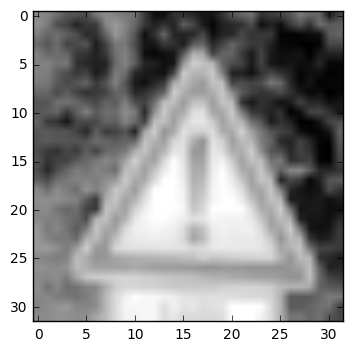

In [64]:
%matplotlib inline
n = 42
img = X_train_final[n]
img = np.squeeze(img, axis=(2,))
print(img.shape)
plt.figure()
plt.imshow(img, cmap="gray")
print(y_train_final[n])

In [65]:
# Run training

with tf.Session() as sess:
    
    sess.run(init)
    for epoch in range(training_epochs):
        total_batch = int(n_train/batch_size)
        
        # shuffle data index for each epoch
        rand_idx = np.random.permutation(n_train)

        for i in range(total_batch):
            offset = i*batch_size
            off_end = offset+batch_size
            batch_idx = rand_idx[offset:off_end]
            
            batch_x = X_train_final[batch_idx]
            batch_y = y_train_final[batch_idx]

            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
        
        cost_ts, acc_ts = sess.run([cost, accuracy], feed_dict={x: X_validation_final, y: y_validation_final})

        print("Cost:  {:.5f}  | Accuracy:  {:.5f}".format(cost_ts, acc_ts))
    
    save_path = saver.save(sess, "model/LeNet.ckpt")
    print("Training Complete! Model saved in file: %s" % save_path)

Cost:  3.49109  | Accuracy:  0.05526
Cost:  3.32524  | Accuracy:  0.07116
Cost:  2.89352  | Accuracy:  0.12454
Cost:  2.59719  | Accuracy:  0.19629
Cost:  2.36284  | Accuracy:  0.25691
Cost:  2.17121  | Accuracy:  0.30035
Cost:  2.04594  | Accuracy:  0.34660
Cost:  1.93893  | Accuracy:  0.38137
Cost:  1.81344  | Accuracy:  0.42710
Cost:  1.71270  | Accuracy:  0.46340
Cost:  1.62213  | Accuracy:  0.48244
Cost:  1.51657  | Accuracy:  0.52130
Cost:  1.43067  | Accuracy:  0.54756
Cost:  1.33709  | Accuracy:  0.57273
Cost:  1.28251  | Accuracy:  0.59492
Cost:  1.21524  | Accuracy:  0.61608
Cost:  1.17198  | Accuracy:  0.62068
Cost:  1.13344  | Accuracy:  0.64312
Cost:  1.08180  | Accuracy:  0.65587
Cost:  1.04998  | Accuracy:  0.66675
Cost:  1.02540  | Accuracy:  0.67695
Cost:  0.98311  | Accuracy:  0.68868
Cost:  0.96061  | Accuracy:  0.69481
Cost:  0.93444  | Accuracy:  0.70450
Cost:  0.92346  | Accuracy:  0.70951
Cost:  0.91494  | Accuracy:  0.70934
Cost:  0.88499  | Accuracy:  0.72269
C

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:** I rewrote the LeNet-5 to work with the new shape of the problem. Since the accuracy of the validation was 96% that looked like a quite good solution that doesn't need specific tuning in terms of batch sizes, epoches, hypermarameters, learning rate, etc.
After I tried to evaluate on the test data I realized that the actual accuracy of the net is pretty bad, so I tried to experiment with the parameters.
Since that didn't really add any better results, I decided to implement AlexNet for a better classification result, however AlexNet crashed my computer so wasn't able to try it out.
I'm however in the process of setting up the AWS instance so I can run it there.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:** I took the LeNet-5 algorithm without too much changes. Then it was more a process of trial and error as well as research to come up with enhanced preprocessing and better neural nets for the image recognition.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [78]:
# Define evaluation function
predicted_labels = tf.argmax(logits_lenet, 1)
top_k = tf.nn.top_k(logits_lenet, 5)

In [79]:
# Pick 10 random images from testing data
sample_indexes = random.sample(range(len(X_test)), 10)
sample_images_input = [X_test_final[i] for i in sample_indexes]
sample_images = [X_test[i] for i in sample_indexes]
sample_labels = [y_test[i] for i in sample_indexes]

In [91]:
# Run the "predicted_labels" on test files
with tf.Session() as sess:
    saver.restore(sess, "model/LeNet.ckpt")
    sess.run(tf.global_variables_initializer())
    [predicted, topk] = sess.run([predicted_labels, top_k], feed_dict={x: sample_images_input})

In [93]:
# Evaluate prediction on test files
for i in range(3):
    print("")
    print("Predicted Class: {} | True Class: {}".format(predicted[i], sample_labels[i]))
    for k in range(5):
        print("label=", topk[1][i][k], "probability=", topk[0][i][k])


Predicted Class: 38 | True Class: 13
label= 38 probability= 2.6203e-11
label= 37 probability= 1.83113e-11
label= 12 probability= 1.76553e-11
label= 21 probability= 1.64679e-11
label= 8 probability= 1.56122e-11

Predicted Class: 14 | True Class: 11
label= 14 probability= 2.73985e-11
label= 32 probability= 2.44201e-11
label= 41 probability= 2.30528e-11
label= 2 probability= 2.26966e-11
label= 42 probability= 1.76819e-11

Predicted Class: 3 | True Class: 31
label= 3 probability= 3.6508e-11
label= 23 probability= 1.87066e-11
label= 17 probability= 1.67559e-11
label= 31 probability= 1.5457e-11
label= 19 probability= 1.51947e-11


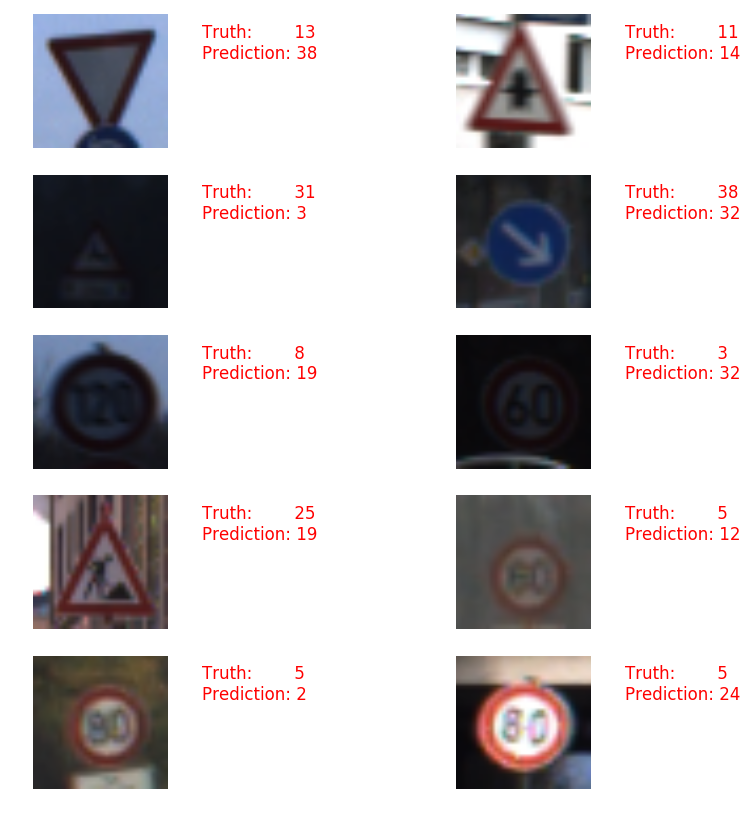

In [94]:
# Display the predictions and the original labelling visually.
%matplotlib inline

fig = plt.figure(figsize=(10, 10))
for i in range(len(sample_images)):
    truth = sample_labels[i]
    prediction = predicted[i]
    plt.subplot(5, 2,1+i)
    plt.axis('off')
    color='green' if truth == prediction else 'red'
    plt.text(40, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), 
             fontsize=12, color=color)
    plt.imshow(sample_images[i])

In [126]:
# Import & prepare images

import os
image_dir = 'test_images/'
new_images = [image_dir+i for i in os.listdir(image_dir)]
new_images = sorted(new_images, key=lambda x: x.split('.')[0])

def read_img(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    return cv2.resize(img, (32, 32), interpolation=cv2.INTER_AREA)

for img in new_images:
    print(img)
    img  = read_img(img)

# labels for new images
# TODO: Change pictures to ones in csv and update labels
y_new = np.array([1,2,3,4,5,6])

X_new = np.ndarray((6, 32, 32, 3), dtype=np.uint8)
for i, img in enumerate(new_images):
    img = read_img(img)
    X_new[i] = img

img = X_new
X_new = preprocess(X_new)
X_new = center_normaize(X_new, mean, std)
print(img.shape)

test_images/40_limit.jpg
test_images/noleft.jpg
test_images/nopark.jpg
test_images/noright.jpg
test_images/noway.jpg
test_images/stop.jpg
(6, 32, 32, 3)


In [127]:
# Run the "predicted_labels" on internet files
with tf.Session() as sess:
    saver.restore(sess, "model/LeNet.ckpt")
    sess.run(tf.global_variables_initializer())
    [predicted, topk] = sess.run([predicted_labels, top_k], feed_dict={x: X_new})

In [128]:
# Evaluate prediction on internet files
for i in range(3):
    print("")
    print("Predicted Class: {} | True Class: {}".format(predicted[i], y_new[i]))
    for k in range(5):
        print("label=", topk[1][i][k], "probability=", topk[0][i][k])


Predicted Class: 6 | True Class: 1
label= 6 probability= 8.36905e-11
label= 5 probability= 8.28476e-11
label= 33 probability= 7.75697e-11
label= 22 probability= 7.04678e-11
label= 26 probability= 6.65198e-11

Predicted Class: 32 | True Class: 2
label= 32 probability= 6.11762e-11
label= 5 probability= 5.94461e-11
label= 18 probability= 5.80329e-11
label= 31 probability= 5.11354e-11
label= 9 probability= 4.8713e-11

Predicted Class: 1 | True Class: 3
label= 1 probability= 3.04929e-11
label= 4 probability= 2.71403e-11
label= 6 probability= 2.3677e-11
label= 34 probability= 2.32943e-11
label= 42 probability= 2.21042e-11


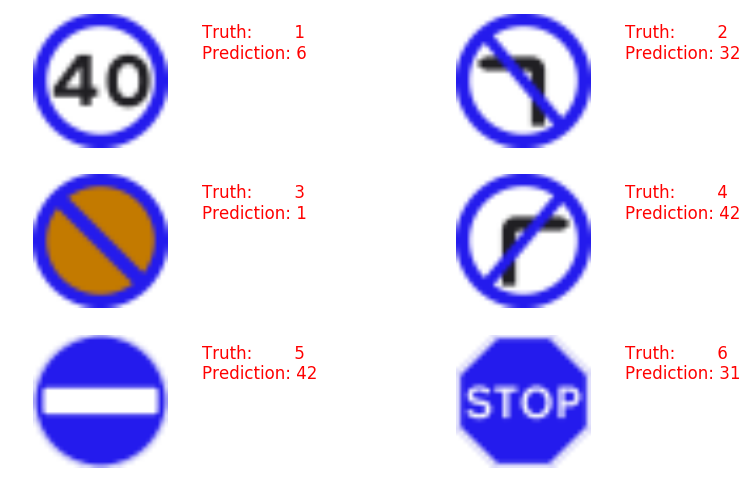

In [130]:
# Display the predictions and the original labelling visually.
%matplotlib inline

fig = plt.figure(figsize=(10, 10))
for i in range(len(X_new)):
    truth = y_new[i]
    prediction = predicted[i]
    plt.subplot(5, 2,1+i)
    plt.axis('off')
    color='green' if truth == prediction else 'red'
    plt.text(40, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), 
             fontsize=12, color=color)
    plt.imshow(img[i])

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:** Currently the import / slicing is not working as expected

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:** I added the accuracy of the predictions to the individual evaluations above. So far data is really bad so no point evaluating

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.